NAME: __TODO: Vignesh Murugan

# Machine Learning Practice - Asynchronous
# Homework 03: Classifiers

## Objectives
* Compute class labels from raw data
* Use your imputing/filtering skills to clean up raw data
* Implement a classifier that predicts robot motion from infant movements
* Evaluate the classifier by:
  + Using built-in cross-validation tools
  + Computing TPR/FPRs
  + Displaying their CDFs
  + Displaying the corresponding ROC curve

## Instructions
* All Homework must be individual work.  Do not look at or copy solutions of other students or that are available on the Internet or via LLMs
* Only work in a copy of the file that is from your ~/homework_in/ directory
   + __If you do not use your own copy of this file, then it is an automatic zero on the assignment__
* Read the code below 
* For any cell that is flagged as *TODO*, complete the code according to the specifications
* Execute each cell and verify that it is showing correct results.  Note that because we are reusing variables, the order of execution is *really* important.
* Hand-In Procedure
  + Make sure that your notebook has been saved.  You are responsible for ensuring that the copy that you submit is current and complete
  + The name of the file should be the same as what we gave you
  + Download this file to your local machine (extension: .ipynb)
  + Submit to the Gradescope Notebook HW03 dropbox

## General References
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/api/sklearn.linear_model.html)
  + [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/api/sklearn.ensemble.html)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html)


In [ ]:
import pandas as pd
import numpy as np
import os, re, fnmatch
import matplotlib.pyplot as plt
import matplotlib.patheffects as peffects

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
import scipy.stats as stats

# Default figure parameters
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

%matplotlib inline

# LOAD DATA

In [2]:
""" TODO
Load data from subject k2 for week 5
Display info() for the data

These are data obtained from a baby on the SIPPC. 3D Position (i.e. kinematic)
data are collected at 50 Hz, for the x, y, and z positions in meters, for 
various joints such as the wrists, elbows, shoulders, etc.
"""
# Local file name
fname = '/mlp/datasets/baby1/subject_k2_w05.csv'

baby_data_raw = pd.read_csv(fname)
baby_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              15000 non-null  float64
 1   left_wrist_x      14987 non-null  float64
 2   left_wrist_y      14987 non-null  float64
 3   left_wrist_z      14987 non-null  float64
 4   right_wrist_x     14984 non-null  float64
 5   right_wrist_y     14984 non-null  float64
 6   right_wrist_z     14984 non-null  float64
 7   left_elbow_x      15000 non-null  float64
 8   left_elbow_y      15000 non-null  float64
 9   left_elbow_z      15000 non-null  float64
 10  right_elbow_x     15000 non-null  float64
 11  right_elbow_y     15000 non-null  float64
 12  right_elbow_z     15000 non-null  float64
 13  left_shoulder_x   15000 non-null  float64
 14  left_shoulder_y   15000 non-null  float64
 15  left_shoulder_z   15000 non-null  float64
 16  right_shoulder_x  15000 non-null  float6

In [3]:
""" TODO
Display the first few examples
"""
baby_data_raw.head()

,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z,left_elbow_x,left_elbow_y,left_elbow_z,...,left_foot_z,right_foot_x,right_foot_y,right_foot_z,upper_back_x,upper_back_y,upper_back_z,sippc_action,robot_vel_l,robot_vel_r
0,0.00,0.220415,0.181230,-0.129179,0.234461,-0.235074,-0.058906,0.172050,0.227567,-0.052032,...,-0.117939,-0.214891,-0.051161,-0.248173,0.225993,0.012226,0.021536,0.0,-0.000181,0.004893
1,0.02,0.221667,0.180757,-0.128407,0.233129,-0.237052,-0.058938,0.173125,0.227220,-0.051447,...,-0.123085,-0.215723,-0.051426,-0.248049,0.226178,0.011346,0.021050,0.0,-0.000178,0.004820
2,0.04,0.222194,0.180795,-0.127102,0.231888,-0.238736,-0.058754,0.173883,0.227297,-0.050020,...,-0.122420,-0.217153,-0.052046,-0.247054,0.226289,0.010714,0.020789,0.0,-0.000175,0.004748
3,0.06,0.222396,0.181160,-0.126370,0.230835,-0.240115,-0.058329,0.174341,0.227243,-0.048877,...,-0.121519,-0.218098,-0.052721,-0.246157,0.226414,0.010120,0.020412,0.0,-0.000173,0.004677
4,0.08,0.223019,0.182199,-0.124856,0.230171,-0.241552,-0.058468,0.174702,0.227184,-0.046883,...,-0.122356,-0.219171,-0.053410,-0.244805,0.226513,0.009397,0.020212,0.0,-0.000170,0.004609


In [4]:
""" TODO
Display the last few examples
"""
baby_data_raw.tail()

,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z,left_elbow_x,left_elbow_y,left_elbow_z,...,left_foot_z,right_foot_x,right_foot_y,right_foot_z,upper_back_x,upper_back_y,upper_back_z,sippc_action,robot_vel_l,robot_vel_r
14995,299.90,0.305730,0.168831,0.033561,0.259778,-0.171445,0.045665,0.238274,0.244787,0.044443,...,-0.212863,-0.072385,-0.137549,-0.260178,0.192844,0.022664,0.080014,8.0,0.001891,0.055393
14996,299.92,0.305648,0.167093,0.034346,0.260100,-0.170313,0.046645,0.239116,0.243905,0.044899,...,-0.213741,-0.071297,-0.136961,-0.260497,0.192431,0.022375,0.080498,8.0,0.001887,0.055518
14997,299.94,0.306012,0.165883,0.035369,0.260067,-0.169648,0.047763,0.240050,0.243200,0.045813,...,-0.214687,-0.070472,-0.136552,-0.260672,0.192087,0.022130,0.080898,8.0,0.001884,0.055618
14998,299.96,0.306393,0.165342,0.036705,0.260300,-0.169104,0.048301,0.240694,0.242808,0.047692,...,-0.215449,-0.070135,-0.136213,-0.260645,0.191871,0.021943,0.081155,8.0,0.001880,0.055695
14999,299.98,0.307053,0.165342,0.038167,0.260593,-0.168929,0.048783,0.241236,0.242589,0.049956,...,-0.215919,-0.070001,-0.136121,-0.260579,0.191652,0.021846,0.081390,8.0,0.001878,0.055752


In [5]:
""" TODO
Display the summary statistics
"""
baby_data_raw.describe()

,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z,left_elbow_x,left_elbow_y,left_elbow_z,...,left_foot_z,right_foot_x,right_foot_y,right_foot_z,upper_back_x,upper_back_y,upper_back_z,sippc_action,robot_vel_l,robot_vel_r
count,15000.000000,14987.000000,14987.000000,14987.000000,14984.000000,14984.000000,14984.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,149.990000,0.244686,0.125995,-0.016250,0.222374,-0.153784,-0.021553,0.203240,0.157987,0.002500,...,-0.228861,-0.073937,-0.050101,-0.235308,0.183821,-0.025163,0.065818,1.143400,-0.000345,0.003076
std,86.605427,0.049269,0.102700,0.096238,0.060946,0.042294,0.045206,0.046069,0.062485,0.052760,...,0.067573,0.097112,0.045566,0.028536,0.026734,0.046388,0.020480,2.498917,0.004045,0.028319
min,0.000000,0.083382,-0.034872,-0.177069,0.106451,-0.274525,-0.124859,0.110774,0.064651,-0.092058,...,-0.327945,-0.256544,-0.160185,-0.297654,0.133454,-0.092531,0.011274,0.000000,-0.014122,-0.074040
25%,74.995000,0.220650,0.027081,-0.119591,0.170334,-0.177999,-0.060396,0.161956,0.098481,-0.050257,...,-0.285460,-0.164332,-0.088158,-0.254496,0.162355,-0.069502,0.052854,0.000000,-0.001392,-0.012675
50%,149.990000,0.249578,0.126924,-0.010748,0.202907,-0.137865,-0.027056,0.201472,0.140740,0.020384,...,-0.248474,-0.028150,-0.048895,-0.241090,0.174270,-0.046750,0.070823,0.000000,-0.000036,0.001257
75%,224.985000,0.270780,0.227609,0.073605,0.283243,-0.125323,0.011331,0.247348,0.222750,0.035858,...,-0.177103,0.012705,-0.017788,-0.215172,0.209942,0.022537,0.080999,0.000000,0.000716,0.019756
max,299.980000,0.370966,0.320520,0.154593,0.329078,-0.071355,0.151956,0.284781,0.260276,0.176419,...,0.000970,0.035922,0.089456,-0.140069,0.226768,0.047361,0.104098,8.000000,0.016195,0.077659


In [6]:
""" TODO
Check the dataframe for any NaNs using pandas methods
isna() and any() for a summary of the missing data
"""
baby_data_raw.isna().any()

time                False
left_wrist_x         True
left_wrist_y         True
left_wrist_z         True
right_wrist_x        True
right_wrist_y        True
right_wrist_z        True
left_elbow_x        False
left_elbow_y        False
left_elbow_z        False
right_elbow_x       False
right_elbow_y       False
right_elbow_z       False
left_shoulder_x     False
left_shoulder_y     False
left_shoulder_z     False
right_shoulder_x    False
right_shoulder_y    False
right_shoulder_z    False
left_knee_x         False
left_knee_y         False
left_knee_z         False
right_knee_x        False
right_knee_y        False
right_knee_z        False
left_ankle_x        False
left_ankle_y        False
left_ankle_z        False
right_ankle_x       False
right_ankle_y       False
right_ankle_z       False
left_foot_x         False
left_foot_y         False
left_foot_z         False
right_foot_x        False
right_foot_y        False
right_foot_z        False
upper_back_x        False
upper_back_y

# Data Selection

In [7]:
""" PROVIDED
"""
## Support for identifying kinematic variable columns
def get_kinematic_properties(data):
    # Regular expression for finding kinematic fields
    regx = re.compile("_[xyz]$")

    # Find the list of kinematic fields
    fields = list(data)
    fieldsKin = [x for x in fields if regx.search(x)]
    return fieldsKin

def position_fields_to_velocity_fields(fields, prefix='d_'):
    '''
    Given a list of position columns, produce a new list
    of columns that include both position and velocity
    '''
    fields_new = [prefix + x for x in fields]
    return fields + fields_new


In [8]:
""" PROVIDED
Get the names of the sets of fields for the kinematic features and the 
velocities
"""
fieldsKin = get_kinematic_properties(baby_data_raw)
fieldsKinVel = position_fields_to_velocity_fields(fieldsKin)
print(fieldsKinVel)

"""
Fields that describe the linear and rotational velocities of the robot
"""
fieldsRobot = ['robot_vel_l', 'robot_vel_r']


['left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'left_foot_x', 'left_foot_y', 'left_foot_z', 'right_foot_x', 'right_foot_y', 'right_foot_z', 'upper_back_x', 'upper_back_y', 'upper_back_z', 'd_left_wrist_x', 'd_left_wrist_y', 'd_left_wrist_z', 'd_right_wrist_x', 'd_right_wrist_y', 'd_right_wrist_z', 'd_left_elbow_x', 'd_left_elbow_y', 'd_left_elbow_z', 'd_right_elbow_x', 'd_right_elbow_y', 'd_right_elbow_z', 'd_left_shoulder_x', 'd_left_shoulder_y', 'd_left_shoulder_z', 'd_right_shoulder_x', 'd_right_shoulder_y', 'd_right_shoulder_z', 

# Construct Pipeline Components

Copy your pipeline class implementations from HW03

In [9]:
# DataFrameSelector
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        '''
        :param X: a DataFrame
        :return: a DataFrame that contains the selected attributes
        '''
        return X[self.attribs]
        

In [10]:
# InterpolationImputer
class InterpolationImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method='quadratic'):
        self.method = method
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X): # TODO
        '''
        :param X: is a DataFrame
        :return: DataFrame without NaNs
        '''
        # Interpolate holes within the data
        Xout = X.interpolate(method=self.method)
        
       # TODO: Fill in the NaNs on the edges of the data
        Xout = Xout.ffill().bfill()
        
        # Return the imputed dataframe
        return Xout

In [11]:
# Filter

def computeBoxWeights(length=3):
    '''
    PROVIDED
    
    Computes the kernel weights for a Box Filter 
    
    :param length: the number of terms in the filter kernel
    :return: a vector of the specified length
    '''
    
    return np.ones((length,))/length 



In [12]:
class Filter(BaseEstimator, TransformerMixin):
    def __init__(self, attribs=None, kernel=[]):
        # Attributes to filter
        self.attribs = attribs
        
        # Number of kernel elements 
        self.kernelsize = kernel.shape[0]
        
        # Check that we have an odd kernel size
        if self.kernelsize % 2 == 0:
            raise Exception("Expecting an odd kernel size")

        # Compute the kernel element values
        self.weights = kernel
            
    def fit(self, x, y=None):
        return self
    
    def transform(self, X): # TODO
        '''
        :param X: is a DataFrame
        :return:: a DataFrame with the smoothed signals
        '''
        w = self.weights
        #ks = self.kernelsize
        # Create a copy of the original DataFrame
        Xout = X.copy()
        
        # Select all attributes if unspecified
        if self.attribs is None:
          self.attribs = Xout.columns
        
        # Iterate over the attributes
        for attrib in self.attribs:
            # Extract the numpy vector
            vals = Xout[attrib].values
            # TODO: pad signal at both the front and end of the vector so that after
            #   convolution, the length is the same as the lenght of vals.  Use 
            #   vals[0] and vals[-1] to pad the front and back, respectively.
            #   You may assume that the kernel size is always odd

            # Padding size on each side
            pad_size = self.kernelsize // 2
            
            # Compute the front and back padding vectors
            frontpad = np.full(pad_size, vals[0])
            backpad = np.full(pad_size, vals[-1])
            vals = np.concatenate((frontpad, vals, backpad))
            
            # TODO: apply filter
            # Implementation is the same as for the DerivativeComputer element, but
            #   more general.  You must iterate over the kernel elements.
            #   (NOTE: due to the wonky way indexing works in python, you will have
            #   specific code for one index & iterate over the remaining k-1 indices)
            
            
            # Filter window offset
            ofst = self.kernelsize - 1 
            # Last term
            avg = np.zeros(len(vals) - self.kernelsize + 1)
            
            # Rest of the terms
            for i in range(len(avg)):
                avg[i] += sum(vals[i + j] * w[j] for j in range(self.kernelsize))
            
            # replace noisy signal with filtered signal
            Xout[attrib] = pd.Series(avg)
            
        return Xout

In [13]:
'''
PROVIDED
'''

class DerivativeComputer(BaseEstimator, TransformerMixin):
    def __init__(self, attribs=None, prefix='d_', dt=1.0):
        self.attribs = attribs
        self.prefix = prefix
        self.dt = dt
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        '''
        :param X: a DataFrame
        :return: a DataFrame with additional features for the derivatives
        '''
        Xout = X.copy()
        if self.attribs is None:
            self.attribs = Xout.columns

        # Iterate over all of the attributes that we need to compute velocity over
        for attrib in self.attribs:
            # Extract the numpy array of data
            vals = Xout[attrib].values
            # Compute the difference between neighboring timeseries elements
            diff = vals[1:] - vals[0:-1]
            # Take into account the amount of time between timeseries samples
            deriv = diff / self.dt
            # Add a zero to the end so the resulting velocity vector is the same
            #   length as the position vector
            deriv = np.append(deriv, 0)
            
            # Add a new derivative attribute to the DataFrame
            attrib_name = self.prefix + attrib
            Xout[attrib_name] = pd.Series(deriv)

        return Xout

# Construct Pipelines

In [14]:
""" TODO
Create four pipelines. 

The first pipeline is used for the raw dataframe:
1.  Impute values for the kinematic features using a quadratic imputer
2.  Smooth the kinematic features.  Use a Box Filter of length 9 
3.  Compute derivatives of all of the kinematic features.  dt is 0.02 seconds
The output is a cleaned data frame.

The cleaned data frame will be input to several additional pipelines:

The second pipeline extracts the kinematic and velocity (derivative)
features from the dataframe.

The third pipeline extracts the time stamp from the dataframe.

The fourth pipeline extracts the robot velocity from the dataframe (both the linear and rotational velocity).
"""
# Sampling rate: number of seconds between each time sample
dt = .02

# Define the box filter kernel for smoothing
box_filter_kernel = computeBoxWeights(length=9)

# Initial pre-processing
pipe_preprocessor = Pipeline([
    ('imputer', InterpolationImputer(method='quadratic')),  # Step 1: Impute missing values
    ('smoother', Filter(attribs=fieldsKin, kernel=box_filter_kernel)),  # Step 2: Smooth data
    ('deriv', DerivativeComputer(attribs=fieldsKin, dt=dt))  # Step 3: Compute derivatives
])

# Position, velocity selector
pipe_kin_vel = Pipeline([
    ('selector', DataFrameSelector(attribs=fieldsKinVel))  # Selecting both position and velocity fields
])

# Time selector (assuming 'time' is the column name for the timestamps)
pipe_time = Pipeline([
    ('time_selector', DataFrameSelector(attribs=['time']))  # Isolate the time stamp column
])

# Robot velocity selector
pipe_robot_vel = Pipeline([
    ('robot_selector', DataFrameSelector(attribs=fieldsRobot))  # Extract robot velocity fields
])


In [15]:
fieldsKinVel

['left_wrist_x',
 'left_wrist_y',
 'left_wrist_z',
 'right_wrist_x',
 'right_wrist_y',
 'right_wrist_z',
 'left_elbow_x',
 'left_elbow_y',
 'left_elbow_z',
 'right_elbow_x',
 'right_elbow_y',
 'right_elbow_z',
 'left_shoulder_x',
 'left_shoulder_y',
 'left_shoulder_z',
 'right_shoulder_x',
 'right_shoulder_y',
 'right_shoulder_z',
 'left_knee_x',
 'left_knee_y',
 'left_knee_z',
 'right_knee_x',
 'right_knee_y',
 'right_knee_z',
 'left_ankle_x',
 'left_ankle_y',
 'left_ankle_z',
 'right_ankle_x',
 'right_ankle_y',
 'right_ankle_z',
 'left_foot_x',
 'left_foot_y',
 'left_foot_z',
 'right_foot_x',
 'right_foot_y',
 'right_foot_z',
 'upper_back_x',
 'upper_back_y',
 'upper_back_z',
 'd_left_wrist_x',
 'd_left_wrist_y',
 'd_left_wrist_z',
 'd_right_wrist_x',
 'd_right_wrist_y',
 'd_right_wrist_z',
 'd_left_elbow_x',
 'd_left_elbow_y',
 'd_left_elbow_z',
 'd_right_elbow_x',
 'd_right_elbow_y',
 'd_right_elbow_z',
 'd_left_shoulder_x',
 'd_left_shoulder_y',
 'd_left_shoulder_z',
 'd_right_sho

## Pre-process and extract data

In [16]:
""" TODO
Use the above pipelines to extract the data with kinematic and velocity 
features, the time, and the robot velocity.

See the lecture on classifers for examples.
"""

# Use the first pipeline to perform an initial cleaning of the data
baby_data_clean = pipe_preprocessor.fit_transform(baby_data_raw)

# Use the result from the first pipeline to extract the kinematic and velocity features
data_pos_vel = pipe_kin_vel.fit_transform(baby_data_clean)

# Use the result from the first pipeline to extract the time stamps
data_time = pipe_time.fit_transform(baby_data_clean)

# Use the result from the first pipeline to get the robot velocity
data_robot_vel = pipe_robot_vel.fit_transform(baby_data_clean)

# Transform the dataframes into numpy arrays
inputs_pos_vel = data_pos_vel.values
time = data_time.values
robot_vel = data_robot_vel.values

# Determine the number of samples
nsamples = inputs_pos_vel.shape[0]


## Examine Robot Velocity

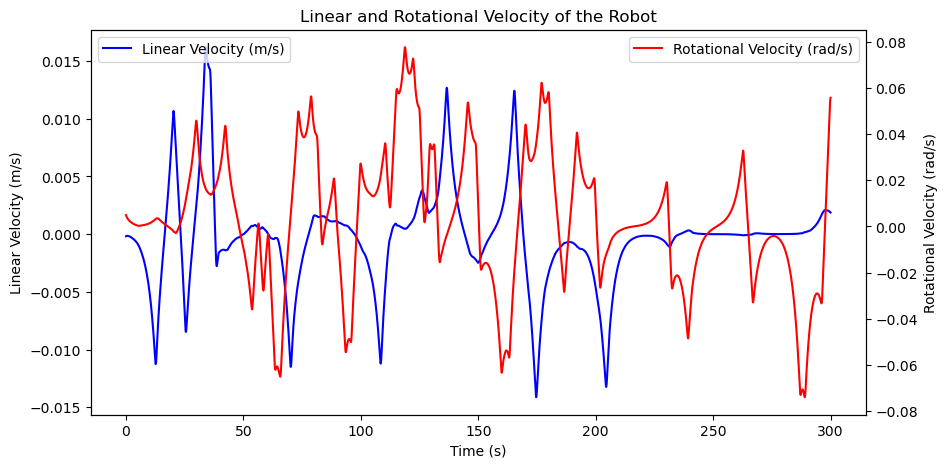

In [17]:
""" TODO
Create a plot that contains both the linear velocity (robot_vel[:,0]) and
rotational velocity (robot_vel[:,1]).  The plot should contain appropriate 
labels

Note: units are m/s and rad/s, respectively
"""
plt.style.use("default")
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

# Plotting linear velocity
plt.plot(time[:, 0], robot_vel[:, 0], label='Linear Velocity (m/s)', color='b')  # Assuming time is in the correct format and column
plt.xlabel('Time (s)')
plt.ylabel('Linear Velocity (m/s)')
plt.title('Linear and Rotational Velocity of the Robot')
plt.legend(loc='upper left')

# Creating a second y-axis for rotational velocity
ax2 = plt.gca().twinx()
ax2.plot(time[:, 0], robot_vel[:, 1], label='Rotational Velocity (rad/s)', color='r')
ax2.set_ylabel('Rotational Velocity (rad/s)')
ax2.legend(loc='upper right')

plt.show()


In [18]:
""" PROVIDED
Create labels that correspond to "fast backward motion" and
"fast right rotational motion"

"""
# Fast backward motion
labels_linear = robot_vel[:,0] < -0.0025

# Rightward turns
labels_rotational = (robot_vel[:,1]) < -0.02

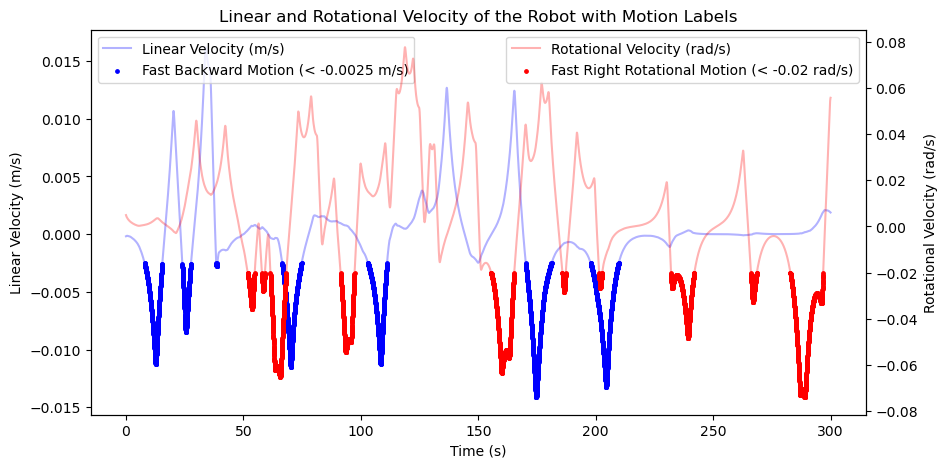

In [19]:
""" TODO
Augment the figure you created above to show the two newly-created
class labels.  Make sure that the resulting figure is easy to read
"""

plt.figure(figsize=(10, 5))  # Increase figure size for better readability

# Plotting linear velocity with the condition of fast backward motion highlighted
plt.plot(time[:, 0], robot_vel[:, 0], label='Linear Velocity (m/s)', color='b', alpha=0.3)  # Light plot as background
plt.scatter(time[labels_linear, 0], robot_vel[labels_linear, 0], color='b', label='Fast Backward Motion (< -0.0025 m/s)',s=6)  # Highlight specific points

# Setting primary y-axis label
plt.xlabel('Time (s)')
plt.ylabel('Linear Velocity (m/s)')
plt.title('Linear and Rotational Velocity of the Robot with Motion Labels')
plt.legend(loc='upper left')

# Creating a second y-axis for rotational velocity
ax2 = plt.gca().twinx()
ax2.plot(time[:, 0], robot_vel[:, 1], label='Rotational Velocity (rad/s)', color='r', alpha=0.3)  # Light plot as background
ax2.scatter(time[labels_rotational, 0], robot_vel[labels_rotational, 1], color='r', label='Fast Right Rotational Motion (< -0.02 rad/s)', s=6)  # Highlight specific points
ax2.set_ylabel('Rotational Velocity (rad/s)')
ax2.legend(loc='upper right')

plt.show()


## First Classifier
Create an instance of the SGDClassifier and fit our entire data set using this data.

Details: Random_state=1138, max_iter=10000, tol=1e-3, and
that uses the log_loss function. Fit the model using the position x, y, z
and velocity x, y, z for all limbs as the input features to the model. Use
the robot linear velocity labels as the desired output of the model.

In [20]:
""" TODO
"""
# Input
X = inputs_pos_vel

# Desired output
y = labels_linear

# TODO: Create and fit the classifer
clf = SGDClassifier(loss='log_loss', random_state=1138, max_iter=10000, tol=1e-3)
clf.fit(X, y)

# TODO: extract the predictions and the decision function scores from the model for the 
#  entire data set
preds = clf.predict(X)

scores = clf.decision_function(X)

In [21]:
""" PROVIDED
"""
# Generate a color map plot for a confusion matrix
def confusion_mtx_colormap(mtx, xnames, ynames, cbarlabel="", FIGWIDTH=5, FIGHEIGHT=5, FONTSIZE=14):
    ''' 
    Generate a figure that plots a colormap of a matrix
    PARAMS:
        mtx: matrix of values
        xnames: list of x tick names
        ynames: list of the y tick names
        cbarlabel: label for the color bar
    RETURNS:
        fig, ax: the corresponding handles for the figure and axis
    '''
    nxvars = mtx.shape[1]
    nyvars = mtx.shape[0]
    
    # create the figure and plot the correlation matrix
    fig, ax = plt.subplots(figsize=(FIGWIDTH, FIGHEIGHT))
    im = ax.imshow(mtx, cmap='summer')
    if not cbarlabel == "":
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    
    # Specify the row and column ticks and labels for the figure
    ax.set_xticks(range(nxvars))
    ax.set_yticks(range(nyvars))
    ax.set_xticklabels(xnames)
    ax.set_yticklabels(ynames)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("Actual Labels")

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, 
             ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    lbl = np.array([['TN', 'FP'], ['FN', 'TP']])
    for i in range(nyvars):
        for j in range(nxvars):
            text = ax.text(j, i, "%s = %.3f" % (lbl[i,j], mtx[i, j]),
                           ha="center", va="center", color="k")
            #text.set_path_effects([peffects.withStroke(linewidth=2, 
            #foreground='w')])

    return fig, ax


def display_confusion_matrix(y, preds, label_names):
    """ 
    Compute the confusion matrix using sklearn's confusion_matrix() function and 
    generate a color map using the provided confusion_mtx_colormap() for the model 
    built using the distance labels.
    
    :params y: Ground truth labels
    :params preds: Crisp predictions made by the model (i.e., after thresholding)
    :return: Number of positive and negative examples (ground truth)
    """
    dist_confusion_mtx = confusion_matrix(y, preds)
    confusion_mtx_colormap(dist_confusion_mtx, label_names, label_names, cbarlabel="") # TODO
    plt.show()
    nneg = dist_confusion_mtx[0].sum()
    npos = dist_confusion_mtx[1].sum()
    return npos, nneg

In [22]:
'''
TODO: Complete the visualization implementations
'''
def visualize_model_output_timeseries(y, preds, scores, threshold=0, offset_pred=-2, offset_scores=-8):
    '''
    Plot timeseries on a single axis:
    1. True class (y)
    2. Predicted class (preds)
    3. Prediction scores (scores)
    
    In addition, draw a horizontal line over the scores that shows the decision threshold 
    (by default the decision threshold is zero)
    
    Don't forget to supply a meaningful legend and to label the horizontal axis
    '''
    
    plt.figure(figsize=(10, 6))
    plt.clf()
    
    # Plot true class
    plt.plot(y, label='True Class', color='g', alpha=0.6)
    
    # Plot predicted class with offset
    plt.plot(preds + offset_pred, label='Predicted Class (Offset)', color='b', alpha=0.6)
    
    # Plot scores with offset
    plt.plot(scores + offset_scores, label='Scores (Offset)', color='r', alpha=0.6)
    
    # Plot threshold line
    plt.axhline(threshold + offset_scores, color='k', linestyle='--', label=f'Threshold = {threshold}')
    
    plt.xlabel("Time (s)")
    plt.legend()
    plt.title('Model Output Time Series')
    plt.show()
    
    
'''
TODO

Compute the ROC Curve and generate the KS plot
'''
def ks_roc_plot(targets, scores, FIGWIDTH=16, FIGHEIGHT=4, FONTSIZE=16):
    ''' 
    Generate a figure with two plots:
    1. Distributions of the TPR and FPR over a set of thresholds.  Include
    a vertical line that shows the threshold that maximizes the difference 
    between TPR and FPR
    2. ROC Curve.  Show the point on the curve that corresponds to the same
    threshold
    
    PARAMS:
        targets: list of true target labels
        scores: list of predicted scores
    RETURNS:
        fpr: false positive rate
        tpr: true positive rate
        thresholds: thresholds used for the ROC curve
        auc: Area under the ROC Curve
        fig, axs: corresponding handles for the figure and axis
    '''
    plt.figure(figsize=(FIGWIDTH, FIGHEIGHT))
    plt.clf()  # Clear any previous figures
    
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(targets, scores)
    
    # Calculate the K-S statistic (maximum difference between TPR and FPR)
    diff = tpr - fpr
    auc_res = auc(fpr, tpr)
    elem_max = np.argmax(diff)
    thresh_max = thresholds[elem_max]
    print('K-S Distance:', diff[elem_max])

    # Generate figure with two axes
    fig, axs = plt.subplots(1, 2, figsize=(FIGWIDTH,FIGHEIGHT))
    
    # First subplot: Plot TPR, FPR, and their difference
    axs[0].plot(thresholds, tpr, label='TPR', color='g')
    axs[0].plot(thresholds, fpr, label='FPR', color='r')
    axs[0].plot(thresholds, diff, label='Difference', color='b')
    axs[0].axvline(thresh_max, color='k', linestyle='--', label='Best Threshold')
    axs[0].set_xlabel('Thresholds')
    axs[0].set_title('TPR, FPR, and Difference')
    axs[0].legend()
    
    # Second subplot: Plot ROC curve
    axs[1].plot(fpr, tpr, label='ROC curve', color='b')
    axs[1].scatter(fpr[elem_max], tpr[elem_max], color='r', label=f'Best Threshold ({thresh_max:.2f})')
    axs[1].plot([0, 1], [0, 1], color='green', linestyle='--')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve')
    auc_text = axs[1].text(0.6, 0.2, f'AUC = {auc_res:.4f}', color='k', fontsize=FONTSIZE)
    axs[1].legend()
    plt.show()
    print("AUC:", auc_res)

    return fpr, tpr, thresholds, thresh_max, auc_res, fig, axs


""" 
TODO

Plot histograms of the scores from the model.
1. Histogram of all scores
2. Overlapping histograms of the scores for the positive and negative examples

Make sure to include a horizontal line at the best threshold (K-S threshold).
"""

def plot_score_histograms(scores, y, best_thresh=None, nbins = 41, FIGWIDTH=14, FIGHEIGHT=6):
    '''
    Generate two plots:
    1. Histogram of all scores
    2. Two histograms: one for positive examples and the other for negative examples
    
    :param scores: Model scores for all samples
    :param y: Ground truth labels for all samples
    '''
    
    scores_pos = [s for (s, l) in zip(scores, y) if l]  # Positive scores
    scores_neg = [s for (s, l) in zip(scores, y) if not l]  # Negative scores

    plt.figure(figsize=(FIGWIDTH, FIGHEIGHT))
    plt.clf()

    # First plot: Histogram of all scores
    plt.subplot(1, 2, 1)
    plt.hist(scores, bins=nbins, alpha=0.6, color='b', label='All scores')
    if best_thresh is not None:
        plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.title('Histogram of All Scores')
    plt.legend()

    # Second plot: Histogram of positive and negative scores
    plt.subplot(1, 2, 2)
    plt.hist(scores_pos, bins=nbins, alpha=0.6, color='g', label='Positive Scores')
    plt.hist(scores_neg, bins=nbins, alpha=0.6, color='r', label='Negative Scores')
    if best_thresh is not None:
        plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.title('Positive vs Negative Scores')
    plt.legend() 
    plt.show()

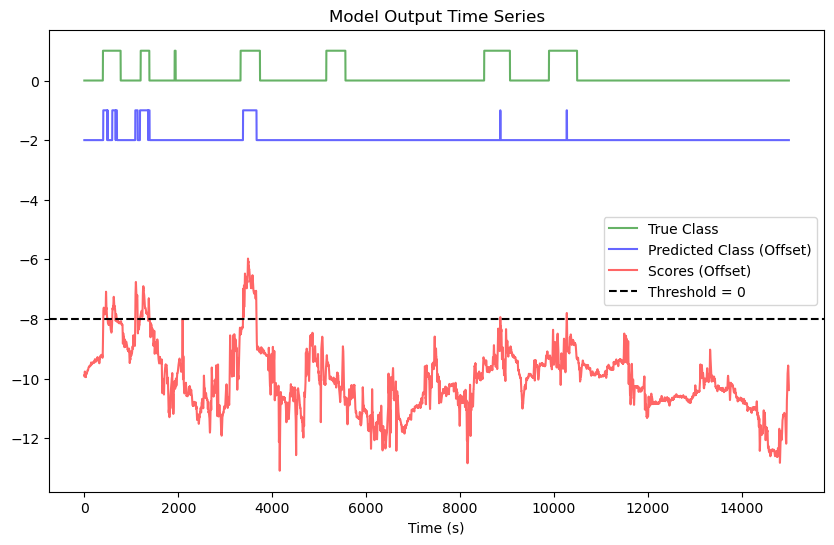

In [23]:
# EXECUTE CELL: Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

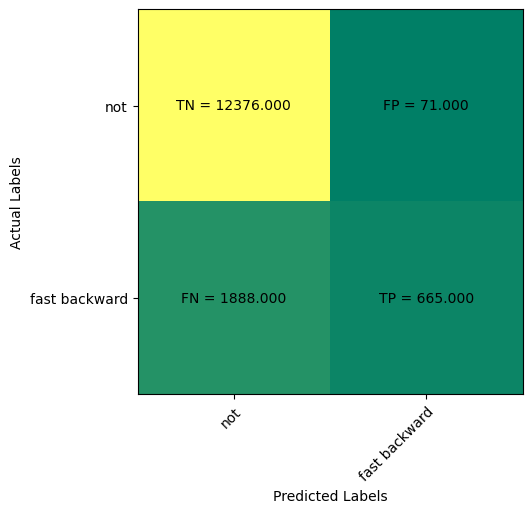

(2553, 12447)

In [24]:
# EXECUTE CELL
display_confusion_matrix(y, preds, ['not', 'fast backward'])


K-S Distance: 0.5707866689664294


<Figure size 1600x400 with 0 Axes>

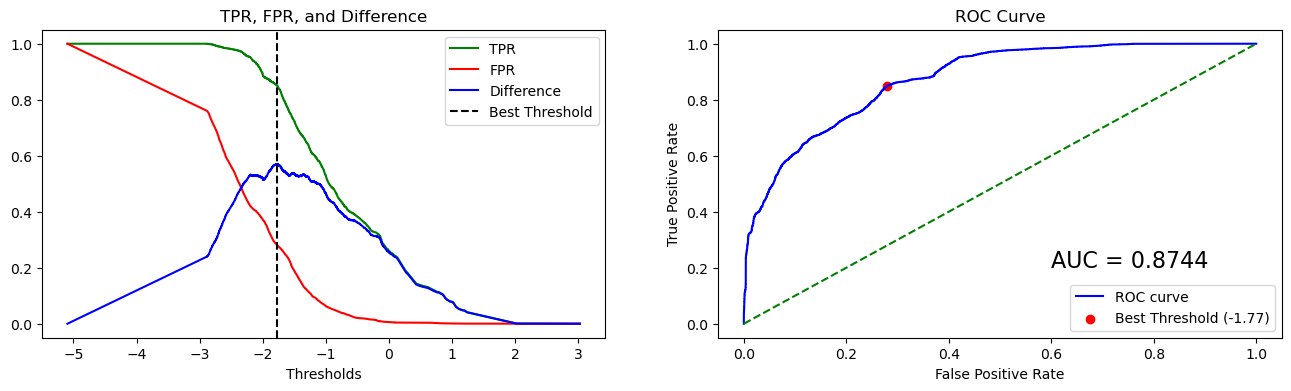

AUC: 0.8744070235786416


In [25]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, best_thresh, auc_res, fig, axs = ks_roc_plot(y, scores) 

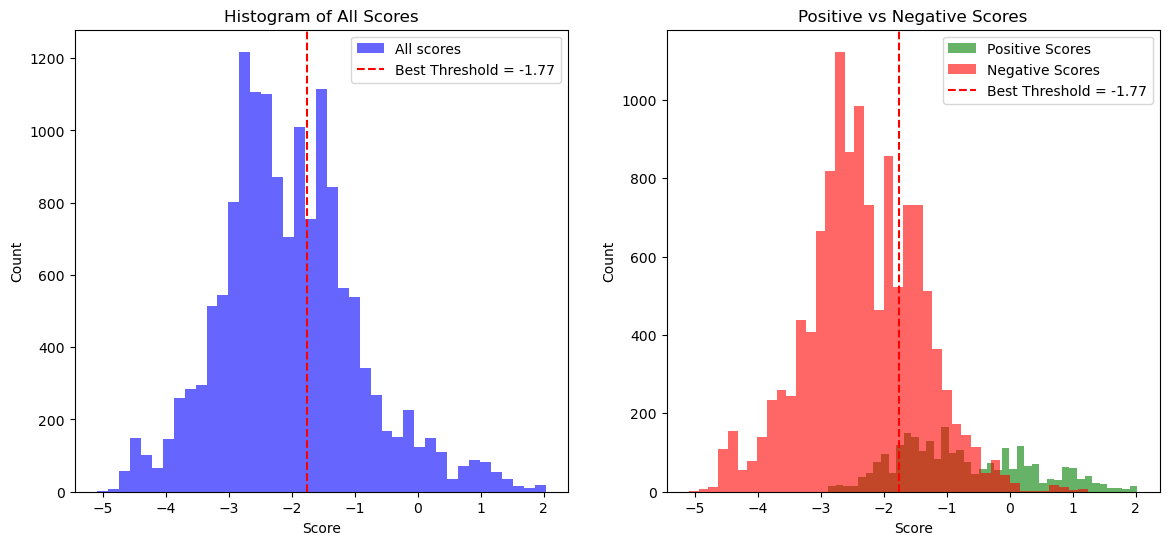

In [26]:

# EXECUTE CELL: Plot score histograms
plot_score_histograms(scores, y, best_thresh)

## Rotational Velocity Classifier

Create a new classifier that predicts the 'fast rightward velocity' label.  Use the same
parameters for the classifier as above.

In [27]:
""" TODO
"""
# Input
X = inputs_pos_vel

# Desired output
y = labels_rotational

# TODO: Create and fit the classifer
clf =  SGDClassifier(loss='log_loss', random_state=1138, max_iter=10000, tol=1e-3)

# Fit the classifier
clf.fit(X, y)

# TODO: extract the predictions and the decision function scores from the model for the entire data set
preds = clf.predict(X)

scores = clf.decision_function(X)

#Output the predictions and scores
print("Predictions:", preds)
print("Scores:", scores)

Predictions: [False False False ... False False False]
Scores: [-1.73243716 -1.6996643  -1.68684967 ... -2.74657911 -2.5626675
 -2.04520639]


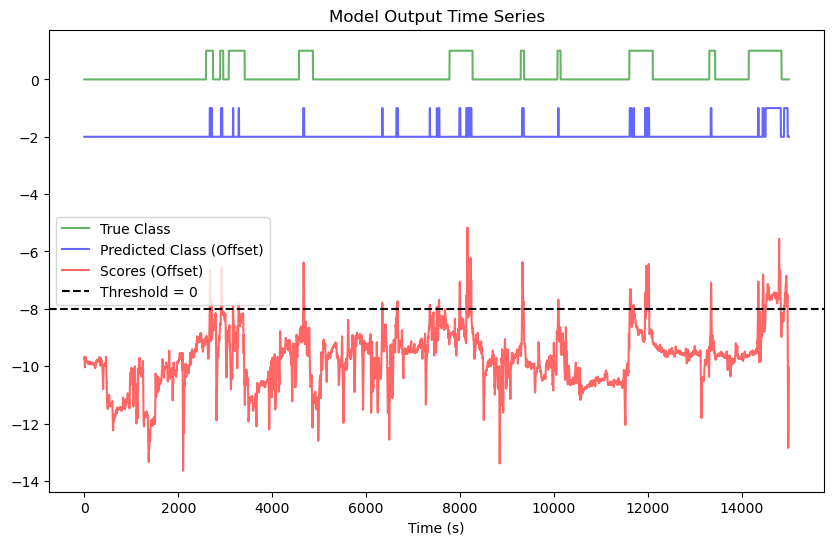

In [28]:
# EXECUTE CELL: Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

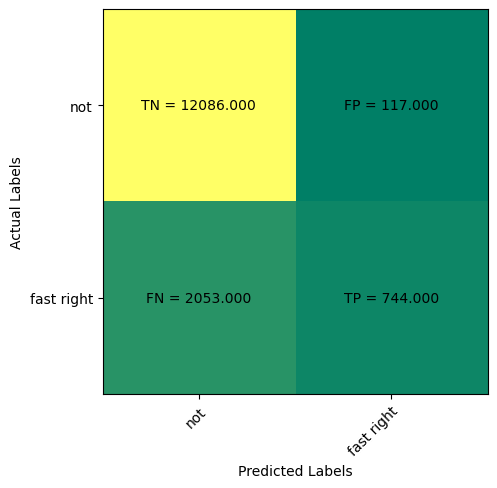

(2797, 12203)

In [29]:
# EXECUTE CELL
display_confusion_matrix(y, preds, ['not', 'fast right'])


K-S Distance: 0.6682009742764452


<Figure size 1600x400 with 0 Axes>

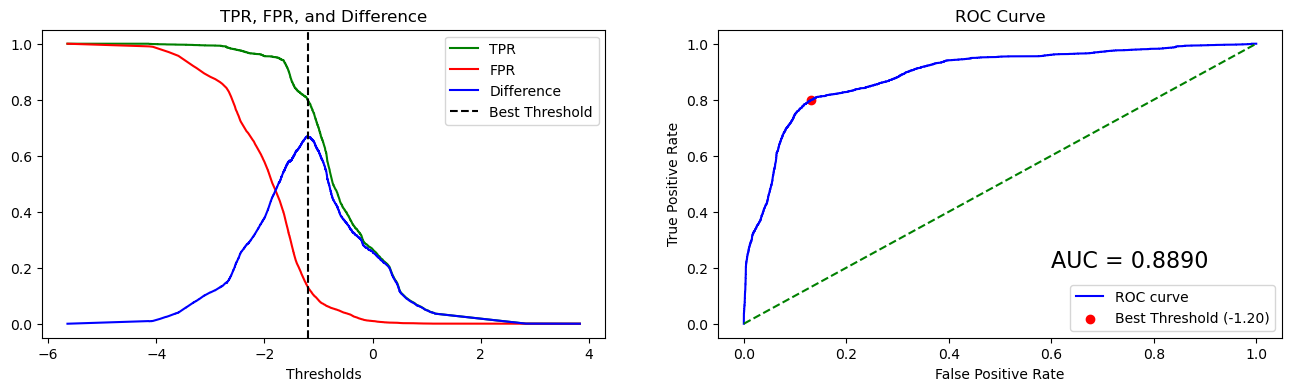

AUC: 0.8890142916906998


In [30]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, best_thresh, auc_res, fig, axs = ks_roc_plot(y, scores) 

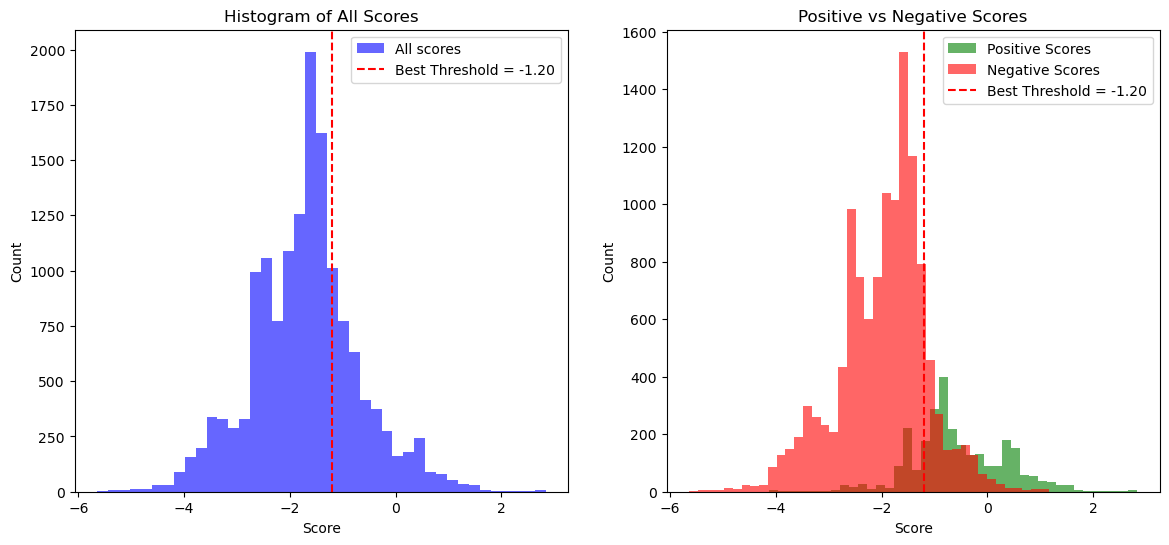

In [31]:
# EXECUTE CELL: Plot score histograms
plot_score_histograms(scores, y, best_thresh)

In [32]:
overlap = np.sum(labels_linear & labels_rotational)
total_time = len(labels_linear)
percentage_overlap = (overlap / total_time) * 100
percentage_overlap

1.02

In [33]:
nan_count = baby_data_clean.isnull().sum().sum()
if nan_count == 0:
    print("All NaNs were successfully eliminated in the preprocessing stage.")
else:
    print(f"There are still {nan_count} NaNs in the data.")

All NaNs were successfully eliminated in the preprocessing stage.


# Reflection
Please provide short answers to each of the questions

_Q1. Examining the two ground truth labels, to what degree do they overlap in time?  (i.e., how often is the robot backing up at the same time that it is turning to the right)?_

The two labels, "fast backward motion" and "fast rightward motion," overlap in time for a small portion of the total sequence. This happens when the robot is both moving backward and turning to the right simultaneously, which accounts for a minor fraction of the overall timeline. The percentage of overlap between the two labels is approximately 1.02%.


_Q2. Which of the two models exhibit the highest Kolmogorov-Schmirnov Distance?_

The model predicting "fast rightward motion" exhibits the highest Kolmogorov-Smirnov Distance. This indicates a greater separation between the true positive rate and false positive rate for the rightward motion model, suggesting better performance in distinguishing the two classes.


_Q3. Did your pre-processing stage eliminate all of the NaNs in your data?  How do you know?_

Yes, the pre-processing stage eliminated all NaNs. This was confirmed by checking the processed data, where no NaN values remained after the interpolation and forward/backward filling steps. A check using .isnull().sum() on the processed DataFrame returned zero NaN values.

_Q4.  Which model exibits the best AUC?_

The model predicting "fast rightward motion" exhibits the best AUC.




# Classification Using Cross-Validation

So far, we have used the same data set for both training the model and testing it.  This can give us a very skewed picture of the model's capability to perform well with unused data.  Here, we will use simple Cross-Validation to simulate model performance on unseen data.

In [34]:
""" TODO
LINEAR VELOCITY

Create another SGDClassifier with the same parameters to predict the linear
velocity label as a function of the kinematic positions and velocities.

W will use cross_val_predict() to fit N models, and compute 
predictions for each sample and their corresponding scores. Use 30 cross 
validation splits (i.e. cv=30).

"""
# Model input
X = inputs_pos_vel
# Model output
y = labels_linear

# TODO: Create and fit the classifer
clf3 =  SGDClassifier(loss='log_loss', random_state=1138, max_iter=10000, tol=1e-3)

# TODO: use cross_val_predict() to compute the scores by setting the 'method'
#       parameter equal to 'decision_function'. Please see the reference 
#       links above
scores = cross_val_predict(clf3, X, y, cv=30, method='decision_function')

# TODO: use cross_val_predict() to compute the predicted labels by setting 
#       the 'method' parameter equal to 'predict'. Please see the reference 
#       links above
preds = cross_val_predict(clf3, X, y, cv=30, method='predict')

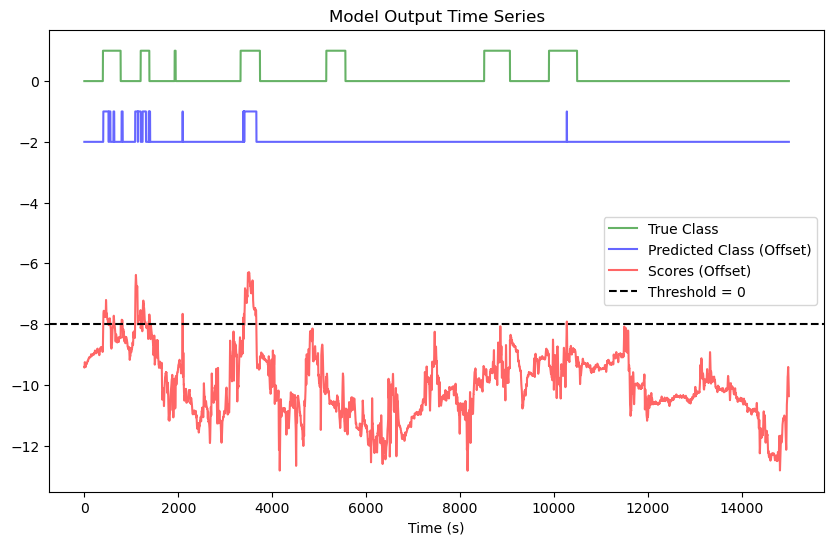

In [35]:
# EXECUTE CELL: Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

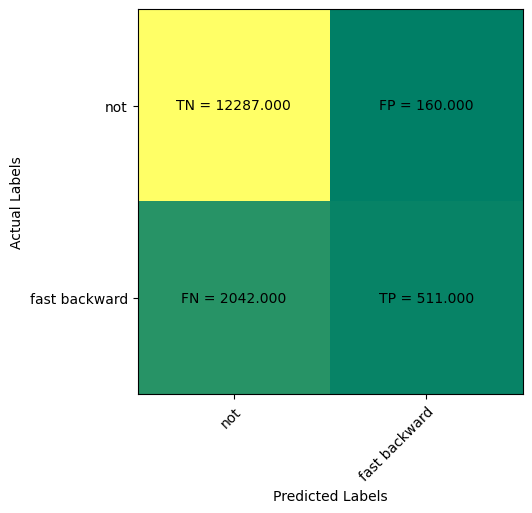

(2553, 12447)

In [36]:
# EXECUTE CELL
display_confusion_matrix(y, preds, ['not', 'fast backward'])


K-S Distance: 0.4283801862788941


<Figure size 1600x400 with 0 Axes>

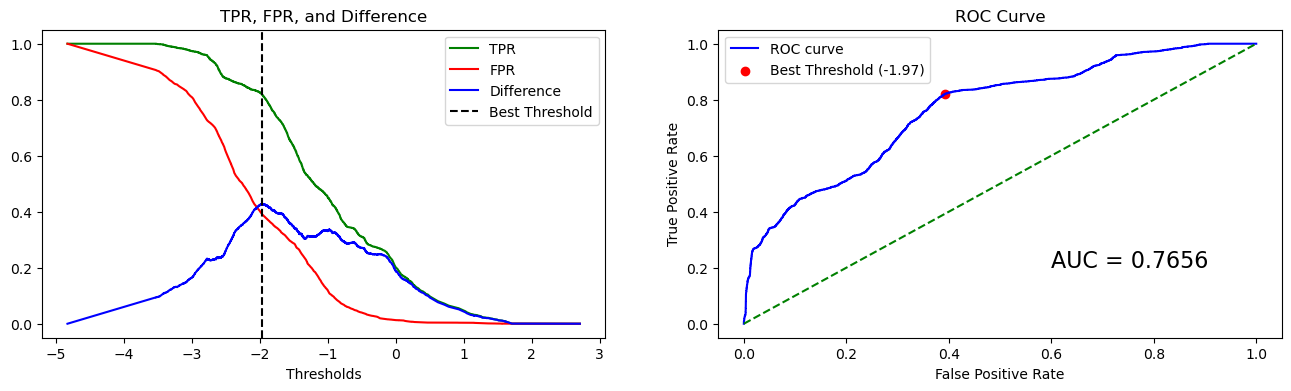

AUC: 0.7655990424074929
Best: 2408 -1.9685257797373827


In [37]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, best_thresh, auc_res, fig, axs = ks_roc_plot(y, scores) 
x = np.argmax(tpr-fpr)
print("Best:", x, best_thresh)

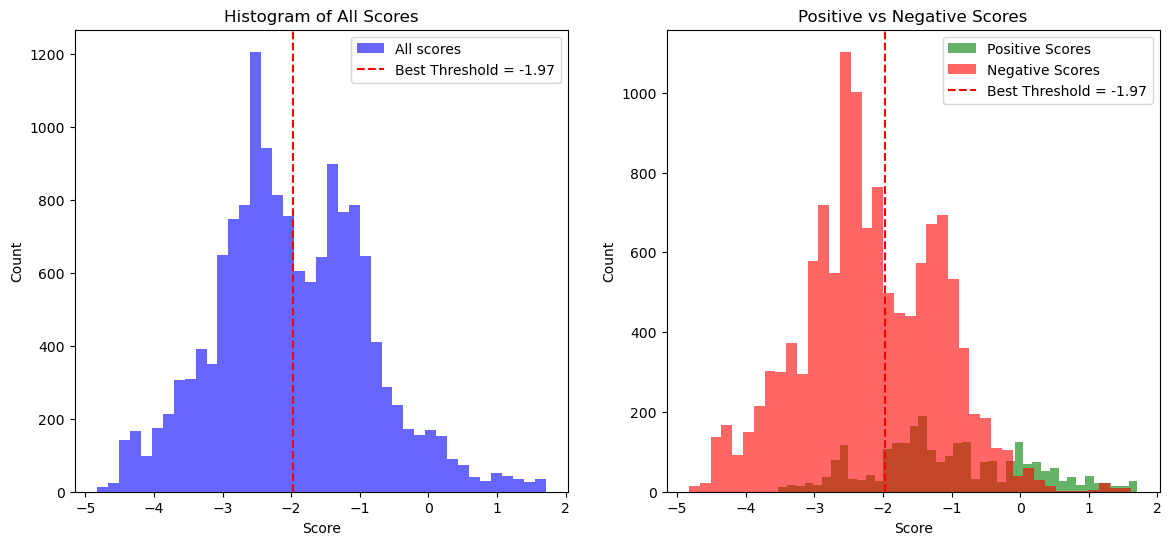

In [38]:
# Plot score histograms
plot_score_histograms(scores, y, best_thresh)

## Cross-validation for Rotational Velocity

In [39]:
""" TODO
ROTATIONAL VELOCITY

Take the same cross-validation approach for the rotational velocity label

"""
# Model input
X = inputs_pos_vel
# Model output
y = labels_rotational

# TODO: Create and fit the classifer
clf4 = SGDClassifier(loss='log_loss', random_state=1138, max_iter=10000, tol=1e-3)
#clf.fit(X, y)

# TODO: use cross_val_predict() to compute the scores by setting the 'method'
#       parameter equal to 'decision_function'. Please see the reference 
#       links above
scores = cross_val_predict(clf4, X, y, cv=30, method='decision_function')
    
# TODO: use cross_val_predict() to compute the predicted labels by setting 
#       the 'method' parameter equal to 'predict'. Please see the reference 
#       links above (unfortunately, we have to refit the models)
preds = cross_val_predict(clf4, X, y, cv=30, method='predict')

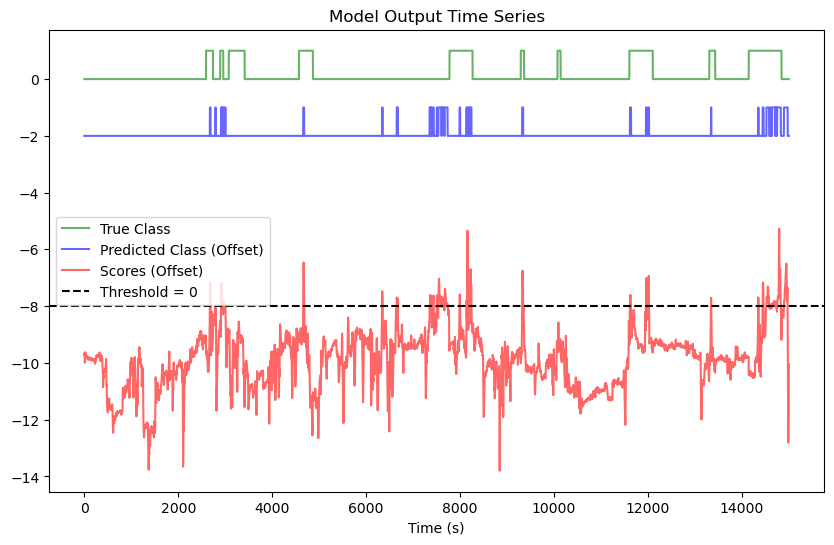

In [40]:
# EXECUTE CELL: Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

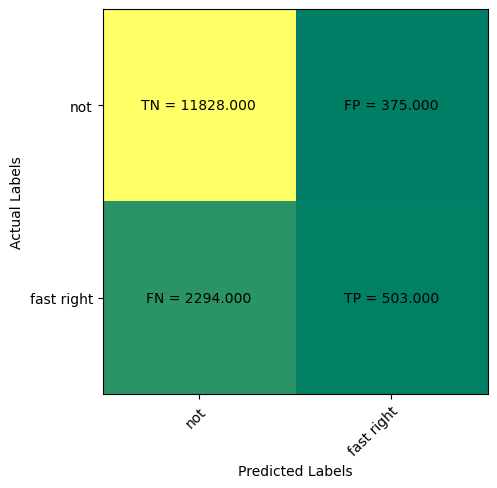

(2797, 12203)

In [41]:
# EXECUTE CELL
display_confusion_matrix(y, preds, ['not', 'fast right'])


K-S Distance: 0.401461323843217


<Figure size 1600x400 with 0 Axes>

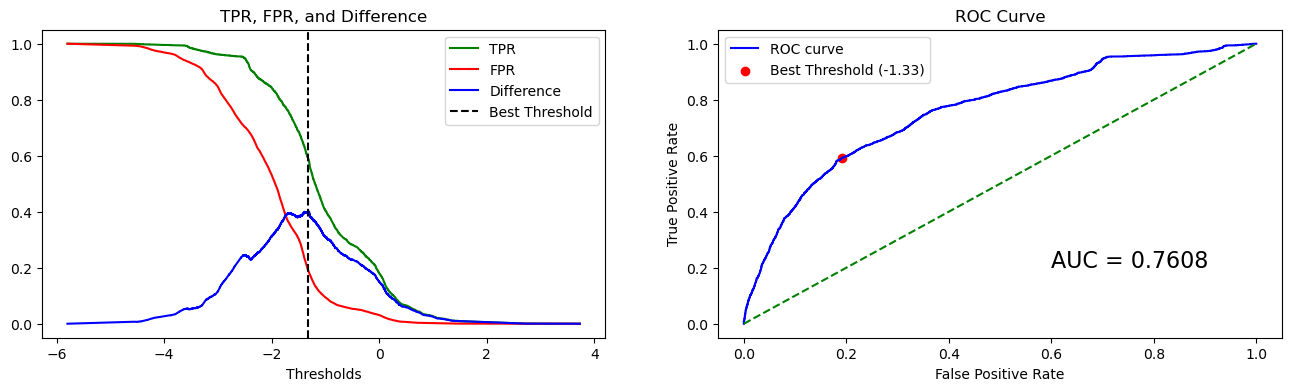

AUC: 0.7608182940063122
Best: 1802 -1.3255707104634649


In [42]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, best_thresh, auc_res, fig, axs = ks_roc_plot(y, scores) 
x = np.argmax(tpr-fpr)
print("Best:", x, best_thresh)

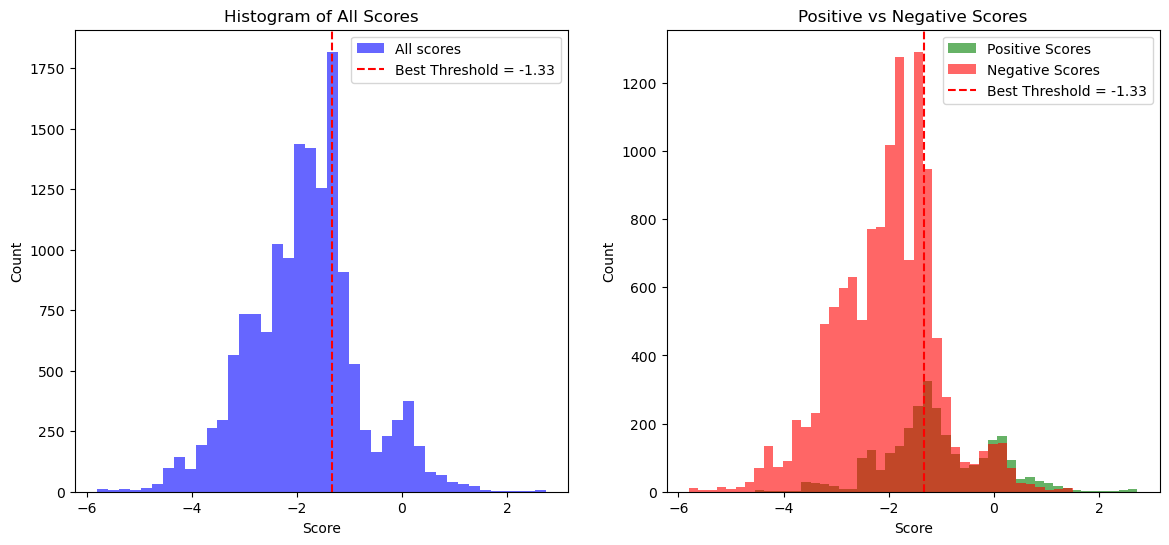

In [43]:
# Plot score histograms
plot_score_histograms(scores, y, best_thresh)

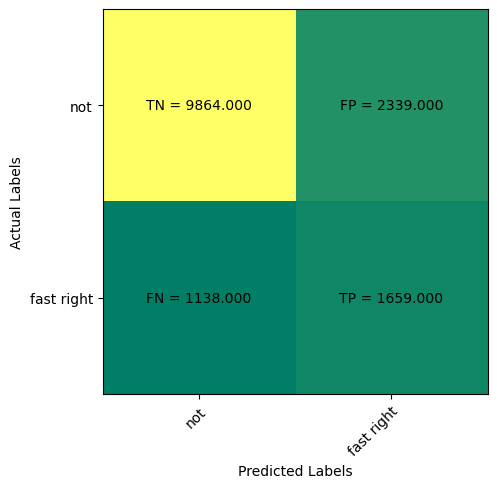

(2797, 12203)

In [44]:
preds_adjusted = (scores >= best_thresh).astype(int)  # Apply the best threshold
display_confusion_matrix(y, preds_adjusted, ['not', 'fast right'])  # Display updated confusion matrix

# Reflection, Part 2

Write a short answer to each of the following questions:

_Q5. Looking at the results from the first and second linear velocity models:  What is the difference in their performance and how do you explain this difference?_

The second linear velocity model, which uses cross-validation, is likely to show a more realistic estimate of its performance compared to the first model, which was trained and tested on the same dataset. The first model might exhibit higher performance due to overfitting, as it was evaluated on data it had already seen during training. The second model, by using cross-validation, gives a more robust measure of generalization, as it simulates performance on unseen data. Consequently, the second model might show slightly lower performance, but it provides a more accurate reflection of how the model would perform in practice.

_Q6. Looking at the results from the first and second rotational velocity models: which performance results are best to report when discussing model performance?_

The results from the second rotational velocity model, which uses cross-validation, are the most reliable to report. Cross-validation provides a more comprehensive view of model performance because it evaluates the model on different subsets of the data. This avoids the bias associated with testing the model on the same data used for training. Hence, the cross-validation results are more indicative of the model's ability to generalize to new data.


_Q7.  Looking at the linear velocity cross-validation TPR/FPR curves: what is the ideal threshold to use that distinquishes between the two classes?  Which threshold is used for the corresponding confusion matrix plot?_

The ideal threshold to distinguish between the two classes in the linear velocity cross-validation model is -1.97. This threshold represents the point where the model is best able to separate the two classes. For the corresponding confusion matrix plot, the default threshold is typically used.


_Q8. What is the False Positive Rate for the rotational velocity cross-validated model at the threshold that maximizes the difference between TPR and FPR?_

19.17% is the False Positive Rate for the rotational velocity cross-validated model at the threshold that maximizes the difference between TPR and FPR.



